<a href="https://colab.research.google.com/github/himsgpt/GenAI_agents/blob/main/langgraph_prompt_automate.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
!pip install langgraph langchain-core pydantic
!pip install python-dotenv
!pip install fireworks-ai

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 570.1/570.1 kB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.7/319.7 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.1/103.1 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 370.6/370.6 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 680.9/680.9 kB 29.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.4/243.4 kB 13.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 7.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [23]:
from typing import List, TypedDict
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import SystemMessage, HumanMessage, ToolMessage
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.runnables import RunnableLambda
from langgraph.checkpoint.memory import InMemorySaver
from fireworks.client import Fireworks

In [29]:
# --------------------------
# 1. Define promptdesign model
# --------------------------

class promptdesign(BaseModel):
    topic: str
    variables: List[str]
    negative_prompt: str
    output_format: str

# --------------------------
# 2. Define LangGraph state type
# --------------------------

class State(TypedDict):
    spec: promptdesign
    messages: List

def llm_call(chat_messages: List[dict]) -> HumanMessage:

  # Initialize client
  api_key="fw_3ZaUhoBEKrVjoowPYn8SzEDn"
  client = Fireworks(api_key=api_key)
  response = client.chat.completions.create(
    model="accounts/fireworks/models/mixtral-8x22b-instruct",
    messages=chat_messages,
    max_tokens=1024,
    temperature=0.1
  )
  ai_response = response.choices[0].message.content
  ai_msg = HumanMessage(content = ai_response)

  return ai_msg

# --------------------------
# 3. Nodes
# --------------------------

def info_node(state: State) -> State:
    """Build system and human messages from promptdesign input"""
    spec = state["spec"]

    system_msg = SystemMessage(
        content=f"You are a prompt engineering assistant. Your task is to design structured prompts for tasks like '{spec.topic}'."
    )

    human_msg = HumanMessage(
        content=(
            f"Design a prompt for: {spec.topic}\n\n"
            f"Required variables: {', '.join(spec.variables)}\n"
            f"Negative instruction: {spec.negative_prompt}\n"
            f"Desired output format: {spec.output_format}"
        )
    )

    return {
        "spec": spec,
        "messages": [system_msg, human_msg],
    }

def add_tool_message(state: State) -> State:
    """Adds a tool message acknowledgment"""
    last_msg = state["messages"][-1]
    tool_msg = ToolMessage(
        content="Acknowledged. Building your prompt now.",
        tool_call_id="tool_123"
    )
    return {
        "spec": state["spec"],
        "messages": state["messages"] + [tool_msg],
    }

def build_prompt(state: State) -> State:
    """Build a ChatPromptTemplate from messages"""
    prompt = ChatPromptTemplate.from_messages(
        state["messages"] + [MessagesPlaceholder(variable_name="history")]
    )
    messages = [
    {"role": "system", "content": m.content} if isinstance(m, SystemMessage)
    else {"role": "user", "content": m.content}
    for m in state["messages"]
    if not isinstance(m, ToolMessage)  # ✅ filter out ToolMessage
    ]
    ai_msg = llm_call(messages)
    return {"spec": state["spec"], "messages": state["messages"] + [ai_msg]}


def final_output(state: State) -> State:
    print("\n✅ LLM Generated Prompt:")
    print(state["messages"][-1].content)
    return state

def decide(state: State) -> str:
    return "call_llm" if any(isinstance(m, ToolMessage) for m in state["messages"]) else "add_tool_msg"


In [32]:
memory = InMemorySaver()
workflow = StateGraph(State)

workflow.add_node("info", RunnableLambda(info_node))
workflow.add_node("add_tool_msg", RunnableLambda(add_tool_message))
workflow.add_node("call_llm", RunnableLambda(build_prompt))
workflow.add_node("final", RunnableLambda(final_output))

workflow.add_conditional_edges("info", decide, {"add_tool_msg": "add_tool_msg", "call_llm": "call_llm"})
workflow.add_edge("add_tool_msg", "call_llm")
workflow.add_edge("call_llm", "final")
workflow.add_edge("final", END)
workflow.add_edge(START, "info")

graph = workflow.compile(checkpointer=memory)

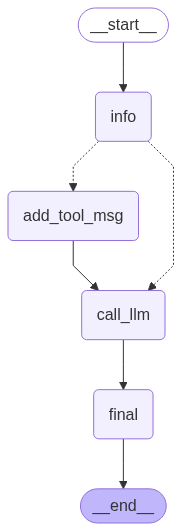

In [33]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

## Invoke

In [34]:
spec = promptdesign(
    topic="RAG pipeline",
    variables=["context", "question"],
    negative_prompt="irrelevant details",
    output_format="bullet points"
)
graph.invoke({"spec": spec, "messages": []}, config={"configurable": {"thread_id": "thread_1"}})

ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7efb027041d0>
ERROR:asyncio:Unclosed client session
client_session: <aiohttp.client.ClientSession object at 0x7efb02833a90>



✅ LLM Generated Prompt:
Title: RAG Pipeline Task

Description:
You are given a context and a question. Your task is to extract relevant information from the context and provide a concise answer to the question using bullet points. Avoid including irrelevant details in your response.

Context: [Insert context here]

Question: [Insert question here]

Desired Output Format:
- Bullet point 1: [Relevant information from context]
- Bullet point 2: [Relevant information from context]
- Bullet point 3: [Relevant information from context]
- ...

Example:
Context: The RAG pipeline is a machine learning model that combines retrieval-augmented generation with a language model. It consists of three main components: a retriever, a reader, and a generator. The retriever fetches relevant documents from a large corpus, the reader extracts information from these documents, and the generator produces the final output based on the extracted information.

Question: What are the main components of the RAG 

{'spec': promptdesign(topic='RAG pipeline', variables=['context', 'question'], negative_prompt='irrelevant details', output_format='bullet points'),
 'messages': [SystemMessage(content="You are a prompt engineering assistant. Your task is to design structured prompts for tasks like 'RAG pipeline'.", additional_kwargs={}, response_metadata={}),
  HumanMessage(content='Design a prompt for: RAG pipeline\n\nRequired variables: context, question\nNegative instruction: irrelevant details\nDesired output format: bullet points', additional_kwargs={}, response_metadata={}),
  ToolMessage(content='Acknowledged. Building your prompt now.', tool_call_id='tool_123'),
  HumanMessage(content='Title: RAG Pipeline Task\n\nDescription:\nYou are given a context and a question. Your task is to extract relevant information from the context and provide a concise answer to the question using bullet points. Avoid including irrelevant details in your response.\n\nContext: [Insert context here]\n\nQuestion: [In

In [ ]:
## Now LLM provider

In [ ]:
import os
import requests
from dotenv import load_dotenv

# Load API key
# load_dotenv(".env")
# api_key = os.getenv("FIREWORKS_API_KEY")
api_key="fw_3ZaUhoBEKrVjoowPYn8SzEDn"
print(f"API Key loaded: {bool(api_key)}")

# Test the actual chat completions endpoint
url = "https://api.fireworks.ai/inference/v1/models"
headers = {
    "Authorization": f"Bearer {api_key}",
    "Content-Type": "application/json",
}

try:
    response = requests.get(url, headers=headers)
    print(f"API Test Status Code: {response.status_code}")

    if response.status_code == 200:
        print("Connection successful! Available models:")
        models = [model['id'] for model in response.json()['data']]
        for model in models:
            print(f" - {model}")
    elif response.status_code == 401:
        print("Error: Invalid API Key. Please verify your Fireworks API key.")
    else:
        print(f"Unexpected response: {response.text}")

except Exception as e:
    print(f"Connection failed: {str(e)}")
    print("Possible issues:")
    print("1. Internet connectivity problem")
    print("2. Fireworks API service outage")
    print("3. Firewall blocking requests to fireworks.ai")

API Key loaded: True
API Test Status Code: 200
Connection successful! Available models:
 - accounts/perplexity/models/r1-1776
 - accounts/fireworks/models/flux-1-dev-fp8
 - accounts/fireworks/models/llama4-scout-instruct-basic
 - accounts/fireworks/models/llama4-maverick-instruct-basic
 - accounts/fireworks/models/llama-v3p1-8b-instruct
 - accounts/fireworks/models/firesearch-ocr-v6
 - accounts/fireworks/models/llama-v3p1-405b-instruct
 - accounts/fireworks/models/mixtral-8x22b-instruct
 - accounts/fireworks/models/flux-kontext-max
 - accounts/fireworks/models/qwen3-coder-480b-a35b-instruct
 - accounts/fireworks/models/qwen3-235b-a22b-instruct-2507
 - accounts/fireworks/models/deepseek-r1-0528
 - accounts/fireworks/models/deepseek-r1-basic
 - accounts/fireworks/models/llama-v3p1-70b-instruct
 - accounts/fireworks/models/llama-v3p3-70b-instruct
 - accounts/fireworks/models/deepseek-r1
 - accounts/fireworks/models/qwen3-30b-a3b
 - accounts/fireworks/models/qwen3-coder-30b-a3b-instruct
 -